In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import joblib

In [39]:
df = pd.read_csv('health_dataset.csv')

X = df[['Temperature', 'ECG', 'SpO2', 'BPM']].values
y = df['Status'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(pd.Categorical(y).codes, dtype=torch.long)

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weights = torch.tensor(class_weights, dtype=torch.float32)


In [40]:
class SuperHealthModel(nn.Module):
    def __init__(self):
        super(SuperHealthModel, self).__init__()
        
        self.fc1 = nn.Linear(4, 128)
        self.bn1 = nn.BatchNorm1d(128)
        
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        
        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        
        self.fc4 = nn.Linear(32, 4)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)

        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        
        x = torch.relu(self.bn3(self.fc3(x)))
        x = self.fc4(x)
        return x


In [ ]:
model = SuperHealthModel()

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 100
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    
    loss.backward()
    optimizer.step()
    
    _, predicted_train = torch.max(outputs, 1)
    correct_train = (predicted_train == y_train).sum().item()
    accuracy_train = 100 * correct_train / y_train.size(0)
    train_accuracies.append(accuracy_train)

    model.eval()
    with torch.no_grad():
        outputs_test = model(X_test)
        _, predicted_test = torch.max(outputs_test, 1)
        correct_test = (predicted_test == y_test).sum().item()
        accuracy_test = 100 * correct_test / y_test.size(0)
        test_accuracies.append(accuracy_test)

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Train Accuracy: {accuracy_train:.2f}%, Test Accuracy: {accuracy_test:.2f}%')


Epoch [10/100], Loss: 1.0820, Train Accuracy: 63.55%, Test Accuracy: 57.06%
Epoch [20/100], Loss: 0.8761, Train Accuracy: 78.05%, Test Accuracy: 79.74%
Epoch [30/100], Loss: 0.7279, Train Accuracy: 84.40%, Test Accuracy: 86.89%
Epoch [40/100], Loss: 0.6166, Train Accuracy: 88.43%, Test Accuracy: 91.67%
Epoch [50/100], Loss: 0.5237, Train Accuracy: 90.09%, Test Accuracy: 93.80%
Epoch [60/100], Loss: 0.4508, Train Accuracy: 91.33%, Test Accuracy: 94.92%
Epoch [70/100], Loss: 0.3921, Train Accuracy: 91.89%, Test Accuracy: 95.69%
Epoch [80/100], Loss: 0.3413, Train Accuracy: 92.69%, Test Accuracy: 96.34%
Epoch [90/100], Loss: 0.3031, Train Accuracy: 93.22%, Test Accuracy: 96.93%
Epoch [100/100], Loss: 0.2679, Train Accuracy: 93.62%, Test Accuracy: 97.16%


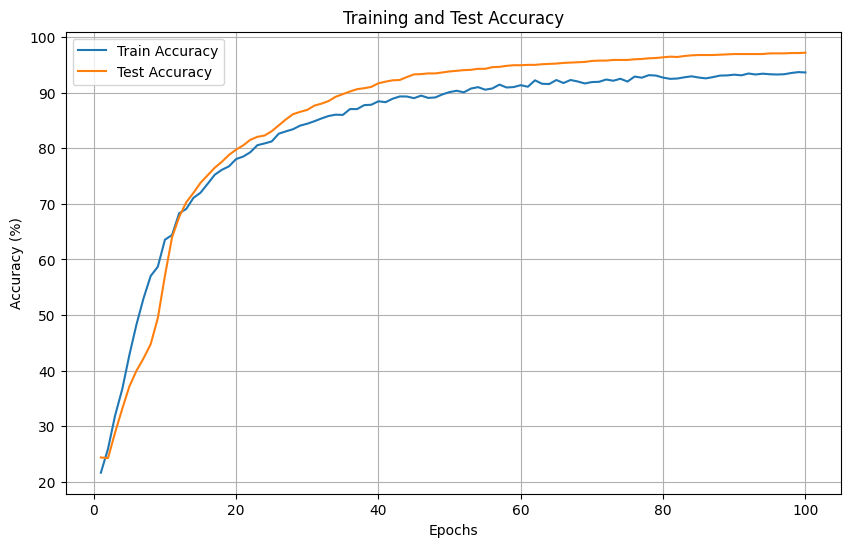

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [45]:
torch.save(model.state_dict(), 'health_super_model.pt')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']